# Processing Estimation Results

This section shows how to obtain and process estimation results.

In [ ]:
# only necessary if you run this in a jupyter notebook
%matplotlib notebook

import matplotlib.pyplot as plt
# to supress nasty warnings:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
# import the base class:
from pydsge import * 
# import all the useful stuff from grgrlib:
from grgrlib import *

### Loading and printing stats

The meta data on estimation results is stored in the numpy-fileformat ``*.npz`` and is by default suffixed by the tag ``_meta``. An example is uploaded with the package. Lets load it...

In [2]:
print(meta_data)
mod = DSGE.load(meta_data)

/home/gboehl/repos/pydsge/pydsge/examples/dfi_doc0_meta.npz


As before, the `mod` object now collects all information and methods for the estimated model. That means you can do all the stuff that you could to before, like running `irfs` or the filter. It also stores some info on the estimation:

In [3]:
info = mod.info()

Title: dfi_doc0
Date: 2020-05-16 00:03:35.615528
Description: the example model
Parameters: 11
Chains: 80
Last 400 of 200 samples



The ``mod`` object provides access to the estimation stats:

In [4]:
summary = mod.mcmc_summary()

            distribution  pst_mean  sd/df   mean     sd   mode  hpd_5  hpd_95  \
theta               beta     0.500  0.100  0.942  0.071  0.782  0.776   0.981   
sigma             normal     1.500  0.375  2.216  0.265  2.252  1.773   2.629   
phi_pi            normal     1.500  0.250  0.851  0.666  2.328  0.257   2.328   
phi_y             normal     0.125  0.050  0.235  0.068  0.116  0.116   0.326   
rho_u               beta     0.500  0.200  0.937  0.013  0.951  0.916   0.957   
rho_r               beta     0.500  0.200  0.834  0.132  0.546  0.579   0.947   
rho_z               beta     0.500  0.200  0.539  0.202  0.997  0.373   1.000   
rho                 beta     0.750  0.100  0.675  0.067  0.810  0.581   0.797   
sig_u   inv_gamma_dynare     0.100  2.000  0.219  0.043  0.167  0.143   0.282   
sig_r   inv_gamma_dynare     0.100  2.000  0.099  0.038  0.169  0.061   0.165   
sig_z   inv_gamma_dynare     0.100  2.000  0.219  0.075  0.102  0.099   0.323   

        mc_error  
theta   

The ``summary`` is a `pandas.DataFrame` object, so you can do fancy things with it like ``summary.to_latex()``. Give it a try.

## Posterior sampling

One major interest is of course to be able to sample from the posterior. Get a sample of 250 draws:

In [5]:
pars = mod.get_par('posterior', nsamples=100, full=True)

Now, essentially everything is quite similar than before, when we sampled from the prior distribution. Let us run a batch of impulse response functions with these

<IPython.core.display.Javascript object>


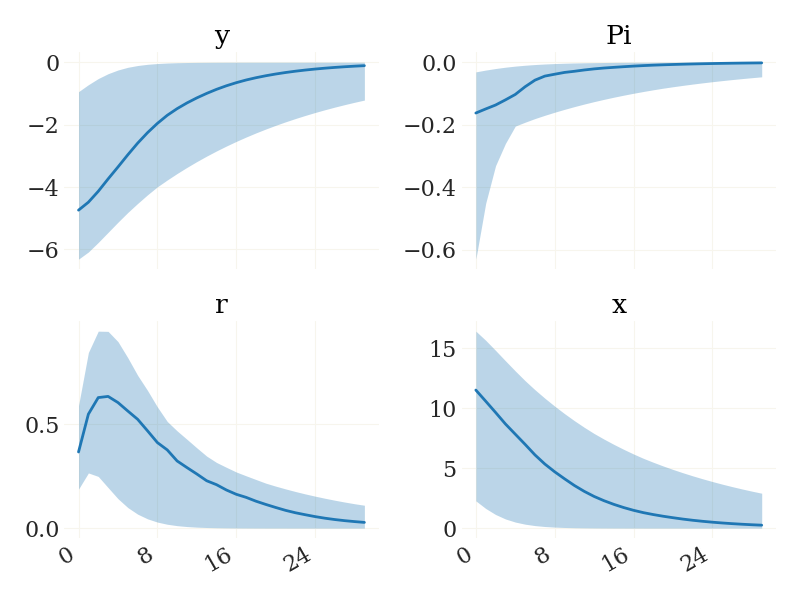

In [6]:
ir0 = mod.irfs(('e_r',1,0), pars)

# plot them:
v = ['y','Pi','r','x']
fig, ax, _ = pplot(ir0[0][...,mod.vix(v)], labels=v)

Note that you can also alter the parameters from the posterior. Lets assume you want to see what would happen if sigma is always one. Then you could create a parameter set like:

In [7]:
pars_sig1 = [mod.set_par('sigma',1,p) for p in pars]

This is in particular interesting if you e.g. want to study the effects of structural monetary policy. We can also extract the smoothened shocks to do some more interesting exercises. But before that, we have to load the filter used during the estimation:

In [13]:
# load filter:
mod.load_estim(reduce_sys=True)
# extract shocks:
epsd = mod.extract(pars, nsamples=1, bound_sigma=10)

[estimation:]   Model operational. 9 states, 3 observables, 88 data points.


100%|██████████| 100/100 [01:32<00:00,  1.08 sample(s)/s]


``epsd`` is a dictionary containing the smoothed means, smoothened observables, the respective shocks and the parameters used for that, as explained in the previous section. Now that we have the shocks, we can again do a historical decomposition or run counterfactual experiments. The `bound_sigma` parameter adjusts the range in which the CMAES algoritm searches for a the set of shocks to fit the time series. A good model combined with a data set without strong irregularities (such as financial crises) should not need a high `bound_sigma`. The small-scale model used here is known to lack a row of empirically relevant features, and the data contains the 2008/2009 financial crisis. Hence, a high `bound_sigma` is necessary to find the smoothed shocks.